In [1]:
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, UpSampling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

# as calculated in step1_coordinates_to_dense_layer_weights.py, used here just to get the correct shape
weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 56x56
        patches_out -- tensor of the original patches center cropped to 48x48 
                       and then downsampled to 24x24
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]  # center-crop to 48x48 (original BRIEF input patch size)
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    patches_in = np.expand_dims(patches_in, -1)
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    patches_out = np.expand_dims(patches_out, -1)
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (58057, 56, 56, 1) ; out (58057, 24, 24, 1)
in (7257, 56, 56, 1) ; out (7257, 24, 24, 1)


In [6]:
input_shape = (input_patch_size, input_patch_size, 1)

# encoder
input_img = Input(shape=input_shape)
x = Conv2D(1, (3,3), activation="relu", padding="valid")(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid")(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid")(flattened)

# decoder
x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [7]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [8]:
model_version = '0.2.1.0.0_wholefromscratch_datagen_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_increasedgeometricnoise_train50more'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(image_datagen.flow(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')  # TODO pokreni sa janice a ne kroz piggy!

Epoch 1/50
58057/58057 [==============================] - 3379s 58ms/step - loss: 0.6803 - val_loss: 0.6707
Epoch 2/50
58057/58057 [==============================] - 3450s 59ms/step - loss: 0.6802 - val_loss: 0.6849
Epoch 3/50
58057/58057 [==============================] - 3316s 57ms/step - loss: 0.6802 - val_loss: 0.6817
Epoch 4/50
58057/58057 [==============================] - 3364s 58ms/step - loss: 0.6802 - val_loss: 0.6761
Epoch 5/50
58057/58057 [==============================] - 3373s 58ms/step - loss: 0.6802 - val_loss: 0.6808
Epoch 6/50
58057/58057 [==============================] - 3428s 59ms/step - loss: 0.6802 - val_loss: 0.6629
Epoch 7/50
58057/58057 [==============================] - 3353s 58ms/step - loss: 0.6326 - val_loss: 0.5493
Epoch 8/50
58057/58057 [==============================] - 3525s 61ms/step - loss: 0.5769 - val_loss: 0.5888
Epoch 9/50
58057/58057 [==============================] - 3507s 60ms/step - loss: 0.5760 - val_loss: 0.6117
Epoch 10/50
58057/58057 [===

original patch:


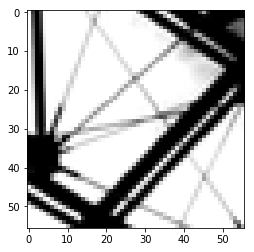

original patch center-cropped and downsampled:


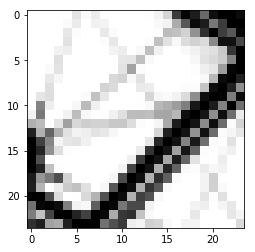

reconstructed patch from its BRIEF encoding:


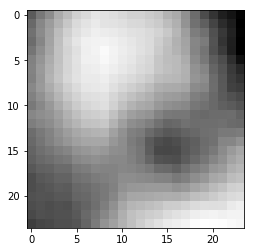

RMSE: 76.9940297305584

original patch:


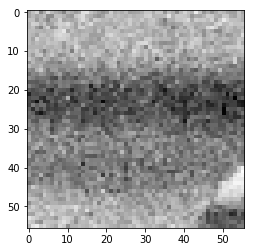

original patch center-cropped and downsampled:


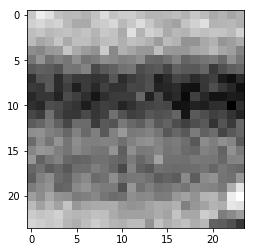

reconstructed patch from its BRIEF encoding:


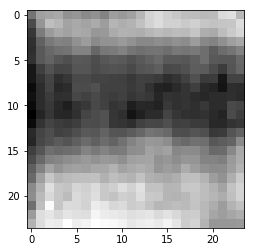

RMSE: 9.166271891444921

original patch:


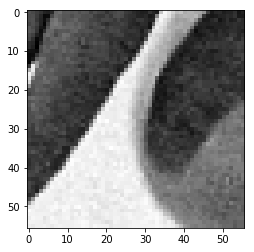

original patch center-cropped and downsampled:


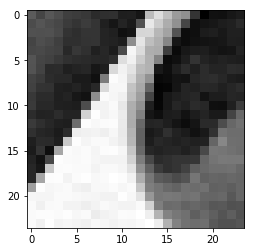

reconstructed patch from its BRIEF encoding:


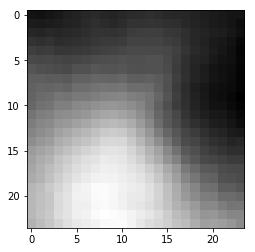

RMSE: 51.57566986978054

original patch:


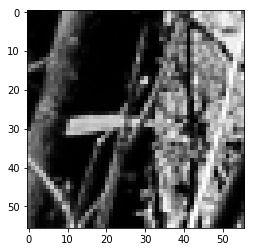

original patch center-cropped and downsampled:


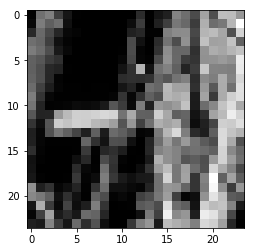

reconstructed patch from its BRIEF encoding:


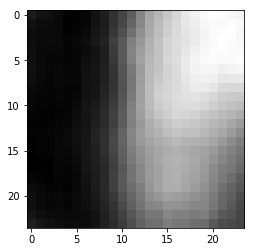

RMSE: 58.51996824145317

original patch:


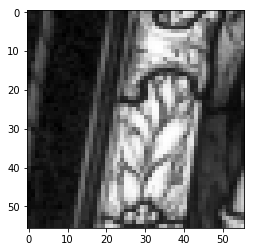

original patch center-cropped and downsampled:


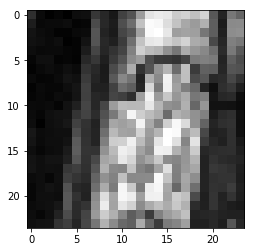

reconstructed patch from its BRIEF encoding:


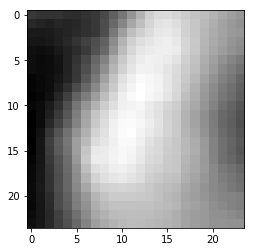

RMSE: 49.05886352062225

original patch:


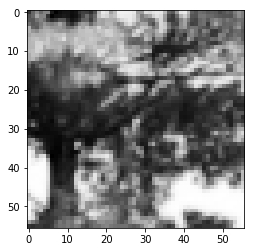

original patch center-cropped and downsampled:


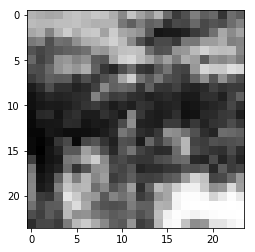

reconstructed patch from its BRIEF encoding:


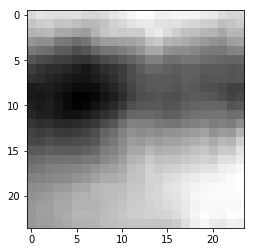

RMSE: 50.03195710480213

original patch:


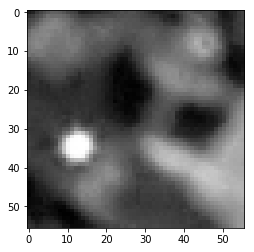

original patch center-cropped and downsampled:


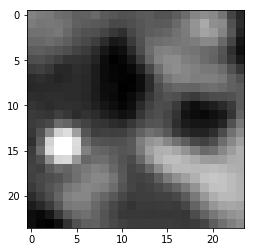

reconstructed patch from its BRIEF encoding:


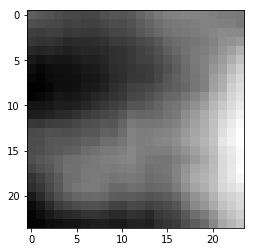

RMSE: 41.94409489631653

original patch:


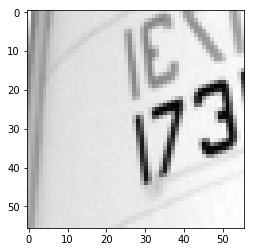

original patch center-cropped and downsampled:


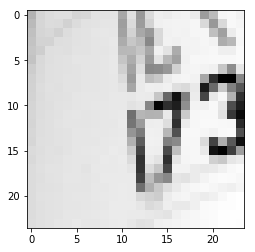

reconstructed patch from its BRIEF encoding:


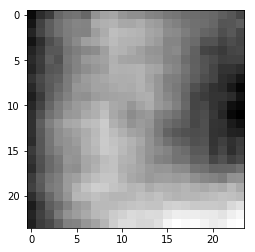

RMSE: 32.57092505693436

original patch:


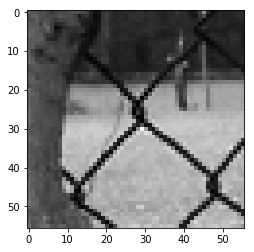

original patch center-cropped and downsampled:


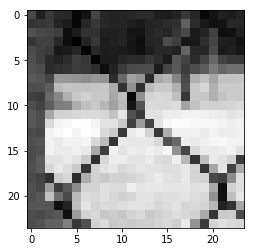

reconstructed patch from its BRIEF encoding:


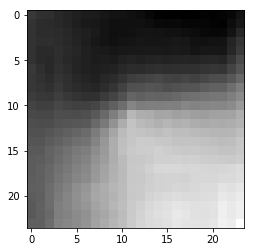

RMSE: 19.776751287281513

original patch:


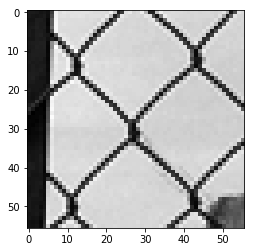

original patch center-cropped and downsampled:


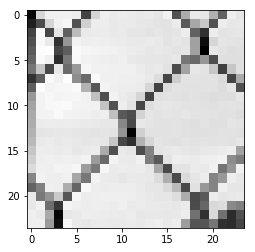

reconstructed patch from its BRIEF encoding:


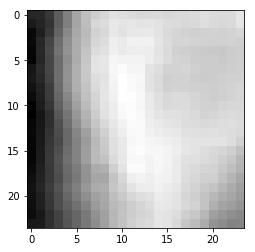

RMSE: 33.54076601564884

average RMSE 0.16595266573131084


In [9]:
# show some reconstructed patches

images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()
files = files[: 10]

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    print("original patch:")
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    print("original patch center-cropped and downsampled:")
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    print("reconstructed patch from its BRIEF encoding:")
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print("RMSE:", rmse * 255)
    rmses += rmse
    
    print("\n==============================================")
    
rmses /= len(images)
print("average RMSE", rmses)